# Bayesian Ridge regression

In [1]:
# Loading modules required for data manipulation an EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading modules required for modelling
from sklearn.linear_model import BayesianRidge          # To access the Bayseian ridge regresssor
from sklearn.model_selection import KFold               # To create training/testing sets
from sklearn.model_selection import GridSearchCV        # To creat a tuning grid for hyperparameters
from sklearn.decomposition import PCA                   # Feature selection tool
from sklearn.pipeline import make_pipeline              # Lets us build a pipeline

# Loading modules to assess error
from sklearn.metrics import mean_squared_error          # To measure the mean of residual errors 
from sklearn.metrics import r2_score                    # To measure the accuracy of the fit

# loading modules to assess model
from sklearn.model_selection import cross_val_score     # To determine the model's cross validation accuracy scores
from sklearn.metrics import accuracy_score              # To determine the model's accuracy
from sklearn.dummy import DummyRegressor                # To create a regressor baseline

# Loading modules to plot confusion matrix
import matplotlib.pyplot as plt                         # This one
import seaborn as sns                                   # ... and this one are used to create figure objects
from sklearn.metrics import confusion_matrix            # To create confusion matrix
%matplotlib inline

#### Feature selection
Ridge models penalise features (but cannot set terms to absolute zero). I will run it with all data first and then be more specific if the accuracy is still low afterwards.

In [2]:
# Importing Data
features = pd.read_csv('X.csv')
target = pd.read_csv('y.csv')

# Ridge regression penalizes unimportant features, reducing them but never making them absolute zero.

## Data Segregation
Splitting the data into 5 folds (80/20 split) and enabling reproducibility.

In [3]:
# Creating numpy arrays of data to get k-folds 
X = np.array(features)
y = np.array(target)
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
print('Number of splits: ', kf.get_n_splits(X))

# Assigning the training and testing sets data based on the splits
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Returning array back to Dataframe
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

# Assessing sets
print('Dataset shapes: ', features.shape, "and ", target.shape)
print('Training set shape: ', X_train.shape, "and", y_train.shape)
print('Testing set shape: ', X_test.shape, "and ", y_test.shape)

Number of splits:  5
Dataset shapes:  (822, 30) and  (822, 1)
Training set shape:  (658, 30) and (658, 1)
Testing set shape:  (164, 30) and  (164, 1)


### Creating baseline
Again, demonstrating the two methods from the course.

In [4]:
# Creating naive baseline to compare with
baseline = np.mean(y_train.iloc[:, 0].to_numpy())
y_baseline = np.repeat(baseline, len(y_test.iloc[:, 0].to_numpy()))
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(naive_MSE)
naive_rr = r2_score(y_test, y_baseline)

# Creating a DummyRegressor baseline
dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict_dummy_mean = dummy_mean.predict(X_test)
dummy_MSE = mean_squared_error(y_test, y_predict_dummy_mean)
dummy_RMSE = np.sqrt(dummy_MSE)
dummy_rr = r2_score(y_test, y_predict_dummy_mean)

## Model Trainning 
Training a model using the default hyperparameters.

In [5]:
# Building the model
model_brr = BayesianRidge()
print("Before optimization with tuning: ", model_brr.get_params())

Before optimization with tuning:  {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'lambda_init': None, 'n_iter': 300, 'normalize': 'deprecated', 'tol': 0.001, 'verbose': False}


In [21]:
# Building the model on training data
model_brr.fit(X_train, y_train.iloc[:, 0].to_numpy())

BayesianRidge()

In [7]:
# Testing the model on training and on testing sets
preds_train_untuned_brr = model_brr.predict(X_train)
preds_test_untuned_brr = model_brr.predict(X_test)

# Deteriming cross fold validation scores
def average(lst):
    return sum(lst) / len(lst)

score_untuned_brr = cross_val_score(model_brr, features, target.iloc[:, 0].to_numpy(), cv = 5)
print("Cross Validation scores (tuned): ", score_untuned_brr, "\nCV score = ", average(score_untuned_brr)) 


# Measuring RMSE
MSE_training_preds = mean_squared_error(y_train, preds_train_untuned_brr)
MSE_testing_preds = mean_squared_error(y_test, preds_test_untuned_brr)

# Measuring RMSE
RMSE_training_preds = np.sqrt(MSE_training_preds)
RMSE_testing_preds = np.sqrt(MSE_testing_preds)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, preds_train_untuned_brr)
rsq_testing_preds = r2_score(y_test, preds_test_untuned_brr)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'Bayesian Ridge on Training', 'Bayesian Ridge on Testing'],
          'MSE': [round(naive_MSE, 5), round(dummy_MSE, 5), round(MSE_training_preds, 5), round(MSE_testing_preds, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RMSE, 5), round(RMSE_training_preds, 5), round(RMSE_testing_preds, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5), round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the untuned model:")
scores_df.head()

Cross Validation scores (tuned):  [0.85526863 0.52262802 0.82762991 0.84938636 0.76516638] 
CV score =  0.7640158593496951

Here are some performace metrics associated with the mean baseline and the untuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,Bayesian Ridge on Training,0.00328,0.05730,0.86221
3,Bayesian Ridge on Testing,0.00366,0.06047,0.84582


## Model Tuning
Creating a grid of values to test through cross validation to identify the best improvement in accuracy.

In [20]:
# Creating model with feature selection (PCA)
pca = PCA(whiten = True,                                # Using uncorrelated components
          random_state = 42)                            # Setting a seed

model_pca_brr = make_pipeline(pca, model_brr)

param_brr = {#"pca__n_components": [1, 3, 5, 10, 15, 20, 25, 30],   No impact observed
            'bayesianridge__alpha_init':[None, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
             'bayesianridge__lambda_init': [None, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]}
# Tuning hyperparameters
tuned_brr = GridSearchCV(model_pca_brr, param_brr, cv = 5)

# Deteriming cross fold validation scores
score_tuned_brr = cross_val_score(tuned_brr, features, target.iloc[:, 0].to_numpy(), cv = 5)
print("Cross Validation scores (tuned): ", score_tuned_brr, "\nCV score = ", average(score_tuned_brr)) 

# Trainning model on training data
tuned_brr.fit(X_train, y_train.iloc[:, 0].to_numpy())
print("\nBest Hyperparameters:")
print(tuned_brr.best_params_)        #output: {'bayesianridge__alpha_init': 1, 'bayesianridge__lambda_init': 0.1}

# Testing model on training and testing set
pca_train_tuned_prediction = tuned_brr.predict(X_train)
pca_test_tuned_prediction = tuned_brr.predict(X_test)

# Measuring MSE 
MSE_training_preds_pca = mean_squared_error(y_train, pca_train_tuned_prediction)
MSE_testing_preds_pca = mean_squared_error(y_test, pca_test_tuned_prediction)

# Measuring RMSE 
RMSE_training_preds_pca = np.sqrt(MSE_training_preds_pca)
RMSE_testing_preds_pca = np.sqrt(MSE_testing_preds_pca)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, pca_train_tuned_prediction)
rsq_testing_preds = r2_score(y_test, pca_test_tuned_prediction)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'Bayesian Ridge on Training', 'Bayesian Ridge on Testing'],
          'MSE ': [round(naive_MSE, 5), round(dummy_MSE, 5), 
                   round(MSE_training_preds_pca, 5), round(MSE_testing_preds_pca, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RMSE, 5), 
                   round(RMSE_training_preds_pca, 5), round(RMSE_testing_preds_pca, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5), round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the tuned model:")
scores_df.head()

Cross Validation scores (tuned):  [0.85965615 0.54090384 0.81287431 0.84835067 0.76859475] 
CV score =  0.7660759444625709

Best Hyperparameters:
{'bayesianridge__alpha_init': 1, 'bayesianridge__lambda_init': None}

Here are some performace metrics associated with the mean baseline and the tuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,Bayesian Ridge on Training,0.00329,0.05731,0.86214
3,Bayesian Ridge on Testing,0.00362,0.06017,0.84736


Text(0, 0.5, 'Fitted values')

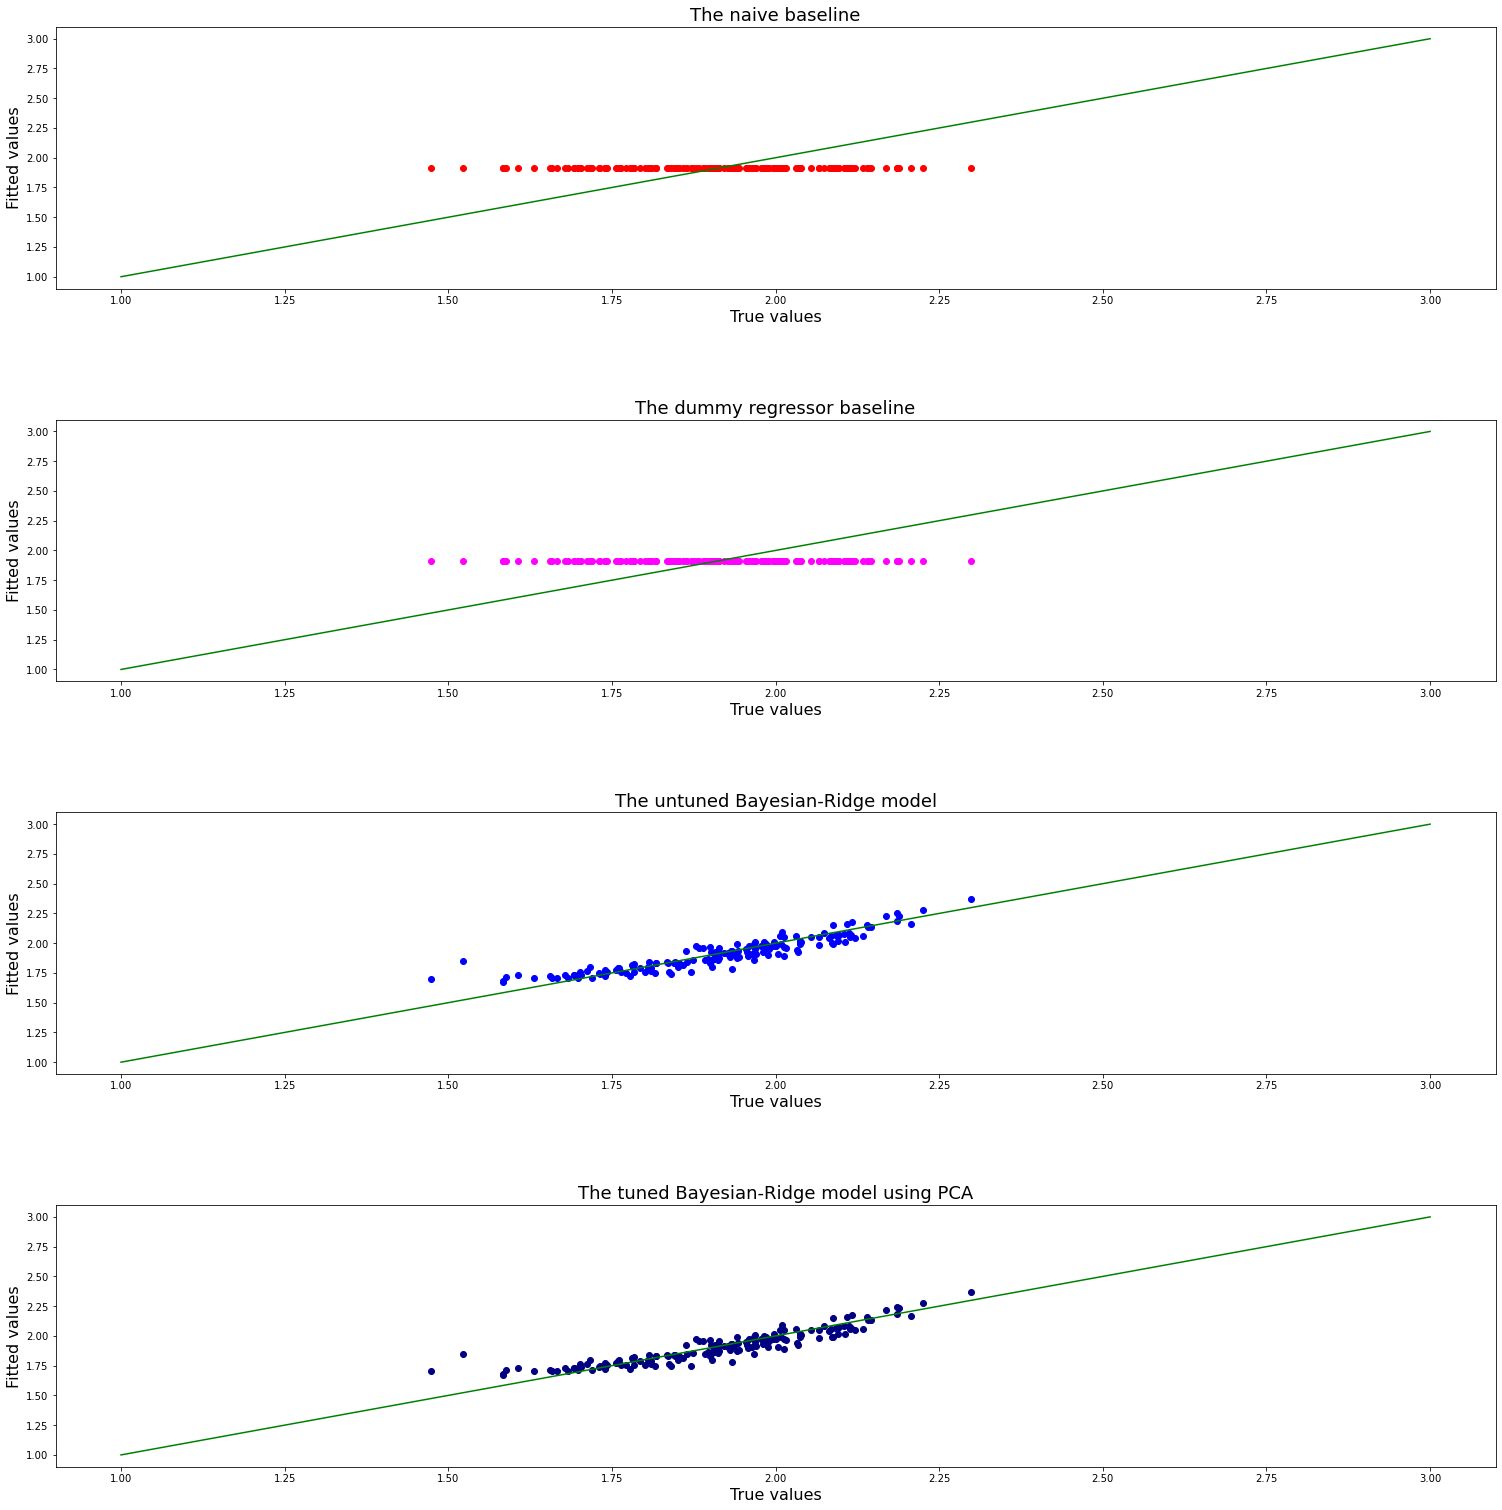

In [22]:
fig = plt.figure(figsize = (20,20))
fig.subplots_adjust( left = 0, right = 1, bottom = 0, top = 1, hspace =0.5, wspace = 0.5)

ax = fig.add_subplot(4,1, 1)
plt.scatter(y_test, y_baseline, color = 'red')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The naive baseline", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(4,1, 2)
plt.scatter(y_test, y_predict_dummy_mean, color = 'magenta')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The dummy regressor baseline", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)


ax = fig.add_subplot(4,1, 3)
plt.scatter(y_test, preds_test_untuned_brr, color = 'blue')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The untuned Bayesian-Ridge model", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(4,1, 4)
plt.scatter(y_test, pca_test_untuned_prediction, color = 'navy')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The tuned Bayesian-Ridge model using PCA", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)